In [85]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy

ModuleNotFoundError: No module named 'unicode'

In [86]:
## Graph Tool
# https://graph-tool.skewed.de/

import graph_tool as gt
from graph_tool.all import *


## Conversion between NetworkX and Graph Tool
# Copied from https://bbengfort.github.io/snippets/2016/06/23/graph-tool-from-networkx.html
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    import graph_tool.all as gt

#    if isinstance(key, unicode):
        # Encode the key as ASCII
#        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    #elif isinstance(value, unicode):
    #    tname = 'string'
    #    value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    import graph_tool.all as gt

    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'nodeid' -- modify as needed!
    gtG.vertex_properties['nodeid'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['nodeid'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

In [2]:
import numpy as np
import palettable
from palettable.colorbrewer.qualitative import Dark2_7
from numpy import genfromtxt
from matplotlib import pyplot as plt
from matplotlib import colors as col
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition


# brewer2mpl.get_map args: set name  set type  number of colors
#bmap = palettable.get_map('Set2', 'qualitative', 8)
#bmapcolors = bmap.mpl_colors
#
#bmap_set3 = palettable.get_map('Set3', 'qualitative', 8)
#bmapcolors_set3 = bmap_set3.mpl_colors

## create colors for markers
cmap = plt.get_cmap('Set1') # choose colormap
cmap = col.ListedColormap(palettable.cartocolors.qualitative.Safe_10.mpl_colors)
# colors=[bmapcolors[6]] #choose three colors by hand
colors=[cmap(0), cmap(2/float(7)), cmap(3), cmap(1), cmap(4)] #choose colors by hand
# colors=[cmap(0), bmapcolors[0], bmapcolors[3], cmap(6/float(9)), bmapcolors[2]] #choose colors by hand
# colors=[cmap(0), bmapcolors[0], cmap(3/float(7)), cmap(6/float(9)), bmapcolors[2]] #choose colors by hand

params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'font.family': 'serif',
   'legend.fontsize': 12,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [7.5, 6]
   }
plt.rcParams.update(params)

# Load Data

In [3]:
##read in globalisation data
OPIX = pd.read_pickle('../../data/OPIX.pkl')
OPIX.rename(columns = {'Openness Index PWT':'OPIX'}, inplace = True)

In [4]:
OPIX

,Year,OPIX
0,1500,NaN
1,1600,NaN
2,1700,NaN
3,1820,NaN
4,1870,NaN
...,...,...
147,2013,58.387039
148,2014,57.883789
149,2015,54.342419
150,2016,52.008652


# Directed Weighted Graphs

In [ ]:
## read in weighted, directed trade data
data = pd.read_pickle('../../data/baci_weighted.pkl')

In [3]:
## create directed graphs from dataframes

G96 = nx.from_pandas_edgelist(data[(data['t']==1996)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G97 = nx.from_pandas_edgelist(data[(data['t']==1997)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G98 = nx.from_pandas_edgelist(data[(data['t']==1998)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G99 = nx.from_pandas_edgelist(data[(data['t']==1999)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G00 = nx.from_pandas_edgelist(data[(data['t']==2000)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G01 = nx.from_pandas_edgelist(data[(data['t']==2001)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G02 = nx.from_pandas_edgelist(data[(data['t']==2002)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G03 = nx.from_pandas_edgelist(data[(data['t']==2003)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G04 = nx.from_pandas_edgelist(data[(data['t']==2004)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G05 = nx.from_pandas_edgelist(data[(data['t']==2005)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G06 = nx.from_pandas_edgelist(data[(data['t']==2006)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())
G07 = nx.from_pandas_edgelist(data[(data['t']==2007)], 'i', 'j', ['v_minmax_scale', 'v_share'], create_using=nx.DiGraph())

##TODO: subset graphs to kgN


In [4]:
## read in graphs

#year_list = ['1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007']
#graph_list = [G96,G97,G98,G99,G00,G01,G02,G03,G04,G05,G06,G07]

#for G,year in zip(graph_list,year_list):
#        G = nx.read_gpickle('../../data/graphs/G'+ year[-2:] +'.gpickle')

In [74]:
print(G07.get_edge_data(156, 842))

{'v_minmax_scale': 1.0, 'v_share': 0.19905747550955094}


In [75]:
print(G07.get_edge_data(842, 156))

{'v_minmax_scale': 0.28128335712934743, 'v_share': 0.055236508539765174}


# Null Model

In [109]:
#Null Model
## read in weighted average, undirected trade data
data_avg = pd.read_pickle('../../data/baci_weighted_average_null.pkl')

## create undirected weighted average graphs from dataframes
M95 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1995)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M96 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1996)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M97 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1997)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M98 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1998)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M99 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1999)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M00 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2000)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M01 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2001)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M02 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2002)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M03 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2003)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M04 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2004)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M05 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2005)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M06 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2006)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M07 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2007)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M08 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2008)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M09 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2009)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M10 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2010)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M11 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2011)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M12 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2012)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M13 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2013)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M14 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2014)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M15 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2015)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M16 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2016)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())
M17 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2017)], 'i', 'j', 'v_mean_scale', create_using=nx.Graph())


graph_list = [M95,M96,M97,M98,M99,M00,M01,M02,M03,M04,M05,M06,M07,M08,M09,M10,M11,M12,M13,M14,M15,M16,M17]


##subset graphs to kgN
node_set_list = [set(M95),set(M96),set(M97),set(M98),set(M99),set(M00),set(M01),set(M02),set(M03),set(M04),set(M05),set(M06),set(M07),set(M08),set(M09),set(M10),set(M11),set(M12),set(M13),set(M14),set(M15),set(M16),set(M17)]

i = set.intersection(*node_set_list)
u = set.union(*node_set_list)

#difference, i.e. nodes not in all networks
c = u.difference(i)
print(c)

# remove nodes from graphs
for M in graph_list:
    M.remove_nodes_from(c)

## check which countries were affected
country_codes = pd.read_csv('../../data/raw/country_codes_V202102.csv', sep=',', quotechar='"', encoding='cp1252')
country_codes.head()

dropped_states = []
for i in c:
    dropped_states.append(country_codes[country_codes['country_code']==i]['country_name_abbreviation'])

# print names
#print(dropped_states)


year_list = ['1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']

# prepare data frame to store results
null_df = pd.DataFrame()
null_df['Year'] = year_list_int
null_df = null_df.merge(OPIX, left_on=['Year'] , right_on=['Year'], how='left')


num_edges = [] # number of edges
dens = [] # network density

avg_cl = [] # average clustering coefficient
deg_ass = [] # degree strength assortativity
deg_ass2 = []


for N in graph_list:
    num_edges.append(nx.number_of_edges(N))
    
    dens.append(nx.density(N))
    

    avg_cl.append(nx.average_clustering(N, weight='v_minmax_avg', count_zeros=False))
    #avg_cl.append(nx.average_clustering(N, count_zeros=False))
    
    
    deg_ass.append(nx.degree_assortativity_coefficient(N, weight='v_minmax_avg'))
    deg_ass2.append(nx.degree_assortativity_coefficient(N))
    


## catch results in dataframe
null_df['Num Edges'] = num_edges
null_df['Density'] = dens
null_df['Average Clustering Coefficient'] = avg_cl
null_df['Assortativity'] = deg_ass 
null_df['Degree Assortativity'] = deg_ass2 

{516, 652, 16, 530, 275, 531, 534, 535, 674, 426, 175, 688, 56, 697, 442, 58, 316, 710, 711, 72, 849, 728, 729, 736, 748, 499, 891}
[138    Namibia
Name: country_name_abbreviation, dtype: object, 175    Saint Barthélemy
Name: country_name_abbreviation, dtype: object, 3    American Samoa
Name: country_name_abbreviation, dtype: object, 142    Neth. Antilles
Name: country_name_abbreviation, dtype: object, 77    State of Palestine
Name: country_name_abbreviation, dtype: object, 143    Curaçao
Name: country_name_abbreviation, dtype: object, 145    Saint Maarten
Name: country_name_abbreviation, dtype: object, 146    Bonaire
Name: country_name_abbreviation, dtype: object, 182    San Marino
Name: country_name_abbreviation, dtype: object, 114    Lesotho
Name: country_name_abbreviation, dtype: object, 47    Mayotte
Name: country_name_abbreviation, dtype: object, 186    Serbia
Name: country_name_abbreviation, dtype: object, 16    Belgium
Name: country_name_abbreviation, dtype: object, 189    Euro

In [110]:
null_df

,Year,OPIX,Num Edges,Density,Average Clustering Coefficient,Assortativity,Degree Assortativity
0,1995,40.851563,10328,0.489131,0.824918,-0.433218,-0.433218
1,1996,41.847786,11059,0.523751,0.828108,-0.402295,-0.402295
2,1997,43.588886,11748,0.556382,0.828396,-0.372321,-0.372321
3,1998,43.267681,12047,0.570542,0.832568,-0.360417,-0.360417
4,1999,43.487377,12285,0.581814,0.833984,-0.347530,-0.347530
5,2000,47.164257,13324,0.631021,0.842986,-0.319390,-0.319390
6,2001,46.009953,13642,0.646081,0.847102,-0.326727,-0.326727
7,2002,46.429943,13848,0.655837,0.848489,-0.318360,-0.318360
8,2003,48.279873,14159,0.670566,0.851517,-0.296801,-0.296801
9,2004,51.768803,14406,0.682264,0.851918,-0.296644,-0.296644


## Undirected Weighted Average Graphs

In [3]:
## read in weighted average, undirected trade data
data_avg = pd.read_pickle('../../data/baci_weighted_average.pkl')

In [4]:
## create undirected weighted average graphs from dataframes
N95 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1995)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N96 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1996)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N97 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1997)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N98 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1998)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N99 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==1999)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N00 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2000)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N01 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2001)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N02 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2002)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N03 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2003)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N04 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2004)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N05 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2005)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N06 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2006)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N07 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2007)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N08 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2008)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N09 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2009)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N10 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2010)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N11 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2011)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N12 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2012)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N13 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2013)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N14 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2014)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N15 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2015)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N16 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2016)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
N17 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2017)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
#N18 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2018)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())
#N19 = nx.from_pandas_edgelist(data_avg[(data_avg['t']==2019)], 'i', 'j', 'v_minmax_avg', create_using=nx.Graph())

In [5]:
graph_list = [N95,N96,N97,N98,N99,N00,N01,N02,N03,N04,N05,N06,N07,N08,N09,N10,N11,N12,N13,N14,N15,N16,N17]


##TODO: subset graphs to kgN
node_set_list = [set(N95),set(N96),set(N97),set(N98),set(N99),set(N00),set(N01),set(N02),set(N03),set(N04),set(N05),set(N06),set(N07),set(N08),set(N09),set(N10),set(N11),set(N12),set(N13),set(N14),set(N15),set(N16),set(N17)]

i = set.intersection(*node_set_list)
u = set.union(*node_set_list)

#difference, i.e. nodes not in all networks
c = u.difference(i)
print(c)

# remove nodes from graphs
for N in graph_list:
    N.remove_nodes_from(c)

## check which countries were affected
country_codes = pd.read_csv('../../data/raw/country_codes_V202102.csv', sep=',', quotechar='"', encoding='cp1252')
country_codes.head()

dropped_states = []
for i in c:
    dropped_states.append(country_codes[country_codes['country_code']==i]['country_name_abbreviation'])

# print names
#print(dropped_states)

{516, 652, 16, 530, 275, 531, 534, 535, 674, 426, 175, 688, 56, 697, 442, 58, 316, 710, 711, 72, 849, 728, 729, 736, 748, 499, 891}


# Analysis

## Globalization

In [8]:
OPIX.dropna()
OPIX2 = OPIX.copy()
year_list_int = [1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017]
OPIX = OPIX[OPIX['Year'].isin(year_list_int)]
OPIX

,Year,OPIX
129,1995,40.851563
130,1996,41.847786
131,1997,43.588886
132,1998,43.267681
133,1999,43.487377
134,2000,47.164257
135,2001,46.009953
136,2002,46.429943
137,2003,48.279873
138,2004,51.768803


In [18]:
## Measure 1
#total traded quantity Q p.a.
total_trade = baci.groupby(by=['t']).sum().reset_index()[['t','q']]

NameError: name 'baci' is not defined

In [19]:
total_trade

NameError: name 'total_trade' is not defined

In [67]:
## Summary statistics

In [9]:
year_list = ['1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']

# prepare data frame to store results
sumdf = pd.DataFrame()
sumdf['Year'] = year_list_int
sumdf = sumdf.merge(OPIX, left_on=['Year'] , right_on=['Year'], how='left')

In [10]:
## Number of Nodes in Networks
n = nx.number_of_nodes(N17)
n

206

In [119]:
print(N96[156][842])
N16[156][842]

{'v_minmax_avg': 0.5105600000502618}


{'v_minmax_avg': 0.7461258000662134}

## Basic properties

In [12]:
num_edges = [] # number of edges
dens = [] # network density
scentr_chi = [] # strength centrality China
scentr_usa = [] # strength centrality USA
scentr_ger = [] # strength centrality GER
scentr_rus= [] # strength centrality RUS
avg_cl = [] # average clustering coefficient
avg_cl2 = [] # average clustering coefficient unweighted
deg_ass = [] # strength assortativity
deg_ass2 = [] # degree assortativity


for N in graph_list:
    num_edges.append(nx.number_of_edges(N))
    
    dens.append(nx.density(N))
    
    scentr_chi.append(N.degree(weight='v_minmax_avg')[156] / (nx.number_of_nodes(N) - 1))
    scentr_usa.append(N.degree(weight='v_minmax_avg')[842] / (nx.number_of_nodes(N) - 1))
    scentr_ger.append(N.degree(weight='v_minmax_avg')[276] / (nx.number_of_nodes(N) - 1))
    scentr_rus.append(N.degree(weight='v_minmax_avg')[643] / (nx.number_of_nodes(N) - 1))


    avg_cl.append(nx.average_clustering(N, weight='v_minmax_avg', count_zeros=False))
    avg_cl2.append(nx.average_clustering(N, count_zeros=False))
    
    
    deg_ass.append(nx.degree_assortativity_coefficient(N, weight='v_minmax_avg'))
    deg_ass2.append(nx.degree_assortativity_coefficient(N))


## catch results in dataframe
sumdf['Num Edges'] = num_edges
sumdf['Density'] = dens

sumdf['Strength Centrality China'] = scentr_chi
sumdf['Strength Centrality USA'] = scentr_usa
sumdf['Strength Centrality GER'] = scentr_ger
sumdf['Strength Centrality RUS'] = scentr_rus

sumdf['Average Clustering Coefficient'] = avg_cl
sumdf['Average Clustering Coefficient unweighted'] = avg_cl2

sumdf['Assortativity'] = deg_ass 
sumdf['Degree Assortativity'] = deg_ass2 


In [13]:
sumdf

,Year,OPIX,Num Edges,Density,Strength Centrality China,Strength Centrality USA,Strength Centrality GER,Strength Centrality RUS,Average Clustering Coefficient,Average Clustering Coefficient unweighted,Assortativity,Degree Assortativity
0,1995,40.851563,10328,0.489131,0.052993,0.226443,0.174075,0.043890,0.009569,0.824918,-0.101916,-0.433218
1,1996,41.847786,11059,0.523751,0.044643,0.227699,0.164271,0.085496,0.009332,0.828108,-0.097269,-0.402295
2,1997,43.588886,11748,0.556382,0.049948,0.235119,0.164661,0.088050,0.009028,0.828396,-0.092384,-0.372321
3,1998,43.267681,12047,0.570542,0.042431,0.247872,0.166764,0.079517,0.008806,0.832568,-0.083324,-0.360417
4,1999,43.487377,12285,0.581814,0.044001,0.250728,0.156286,0.066965,0.008308,0.833984,-0.080969,-0.347530
5,2000,47.164257,13324,0.631021,0.054410,0.253685,0.149666,0.072857,0.007212,0.842986,-0.068503,-0.319390
6,2001,46.009953,13642,0.646081,0.055348,0.256179,0.152964,0.078169,0.007176,0.847102,-0.070010,-0.326727
7,2002,46.429943,13848,0.655837,0.065057,0.247011,0.150531,0.073394,0.007038,0.848489,-0.070704,-0.318360
8,2003,48.279873,14159,0.670566,0.080063,0.254124,0.155043,0.073570,0.006999,0.851517,-0.063165,-0.296801
9,2004,51.768803,14406,0.682264,0.092574,0.245011,0.143244,0.068469,0.006749,0.851918,-0.065327,-0.296644


### Basic Properties

In [14]:
print(sumdf[['Year','Num Edges','Density','Average Clustering Coefficient','Average Clustering Coefficient unweighted','Assortativity','Degree Assortativity']].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Year &  Num Edges &   Density &  Average Clustering Coefficient &  Average Clustering Coefficient unweighted &  Assortativity &  Degree Assortativity \\
\midrule
0  &  1995 &      10328 &  0.489131 &                        0.009569 &                                   0.824918 &      -0.101916 &             -0.433218 \\
1  &  1996 &      11059 &  0.523751 &                        0.009332 &                                   0.828108 &      -0.097269 &             -0.402295 \\
2  &  1997 &      11748 &  0.556382 &                        0.009028 &                                   0.828396 &      -0.092384 &             -0.372321 \\
3  &  1998 &      12047 &  0.570542 &                        0.008806 &                                   0.832568 &      -0.083324 &             -0.360417 \\
4  &  1999 &      12285 &  0.581814 &                        0.008308 &                                   0.833984 &      -0.080969 &             -0.347530 \\
5 

### Assortativity

In [15]:
sumdf.corr()

,Year,OPIX,Num Edges,Density,Strength Centrality China,Strength Centrality USA,Strength Centrality GER,Strength Centrality RUS,Average Clustering Coefficient,Average Clustering Coefficient unweighted,Assortativity,Degree Assortativity
Year,1.000000,0.795970,0.766478,0.766478,0.980834,-0.748929,-0.920194,-0.578500,-0.530103,0.896689,0.387118,0.367413
OPIX,0.795970,1.000000,0.856974,0.856974,0.791176,-0.663707,-0.827894,-0.447236,-0.718111,0.886580,0.569385,0.596997
Num Edges,0.766478,0.856974,1.000000,1.000000,0.722221,-0.491921,-0.868883,-0.347005,-0.924899,0.960788,0.866327,0.850443
Density,0.766478,0.856974,1.000000,1.000000,0.722221,-0.491921,-0.868883,-0.347005,-0.924899,0.960788,0.866327,0.850443
Strength Centrality China,0.980834,0.791176,0.722221,0.722221,1.000000,-0.827729,-0.888210,-0.635681,-0.464649,0.873748,0.333981,0.342409
Strength Centrality USA,-0.748929,-0.663707,-0.491921,-0.491921,-0.827729,1.000000,0.689737,0.567498,0.198253,-0.662511,-0.114169,-0.264494
Strength Centrality GER,-0.920194,-0.827894,-0.868883,-0.868883,-0.888210,0.689737,1.000000,0.469934,0.708146,-0.933428,-0.575574,-0.576119
Strength Centrality RUS,-0.578500,-0.447236,-0.347005,-0.347005,-0.635681,0.567498,0.469934,1.000000,0.205080,-0.508099,-0.121666,-0.125065
Average Clustering Coefficient,-0.530103,-0.718111,-0.924899,-0.924899,-0.464649,0.198253,0.708146,0.205080,1.000000,-0.808795,-0.928188,-0.861593
Average Clustering Coefficient unweighted,0.896689,0.886580,0.960788,0.960788,0.873748,-0.662511,-0.933428,-0.508099,-0.808795,1.000000,0.725759,0.720847


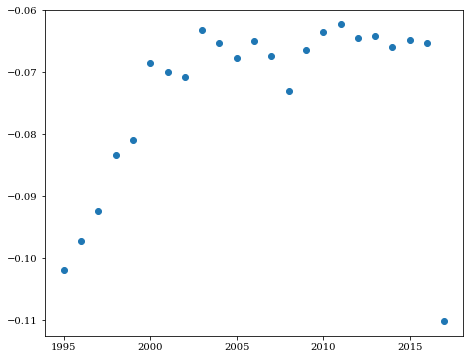

In [17]:
plt.scatter(sumdf['Year'],sumdf['Degree Assortativity'])


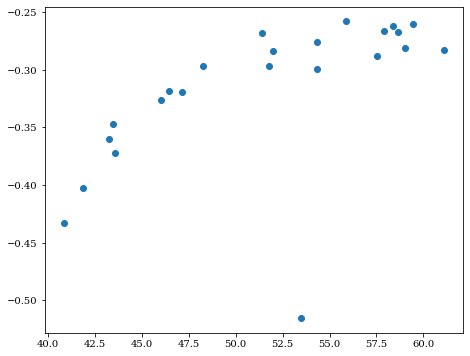

In [103]:
plt.scatter(sumdf['OPIX'],sumdf['Assortativity'])


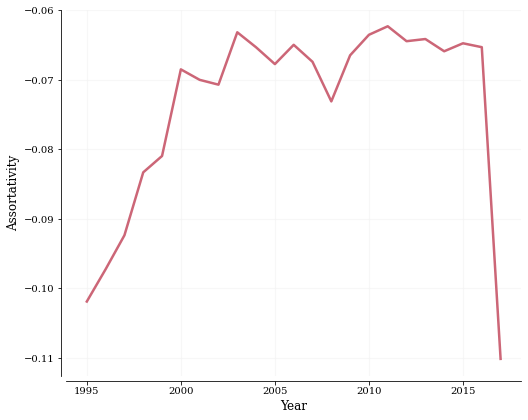

In [90]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.plot(sumdf['Year'], sumdf['Assortativity'], label='Assortativity', color=cmap(1), lw=2.5)

ax.set_xlabel('Year')
ax.set_ylabel('Assortativity')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=-0.11, ymax=-0.06)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

plt.draw()

## save figure to file
fig.savefig('../../figures/'+'assortativity'+'.png', dpi=300)

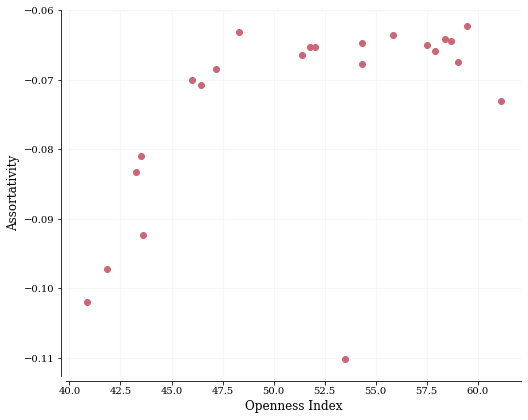

In [93]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.scatter(sumdf['OPIX'], sumdf['Assortativity'], label='Assortativity', color=cmap(1))

ax.set_xlabel('Openness Index')
ax.set_ylabel('Assortativity')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=-0.11, ymax=-0.06)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

plt.draw()

## save figure to file
fig.savefig('../../figures/'+'assortativity_2'+'.png', dpi=300)

### Clustering

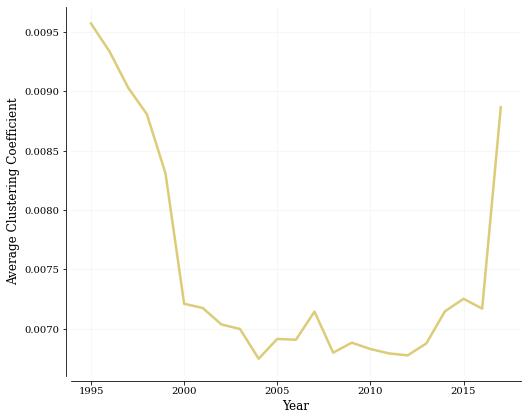

In [94]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.plot(sumdf['Year'], sumdf['Average Clustering Coefficient'], label='Clustering Coefficient', color=cmap(2), lw=2.5)

ax.set_xlabel('Year')
ax.set_ylabel('Average Clustering Coefficient')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=-0.11, ymax=-0.06)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

plt.draw()

## save figure to file
fig.savefig('../../figures/'+'clustering'+'.png', dpi=300)

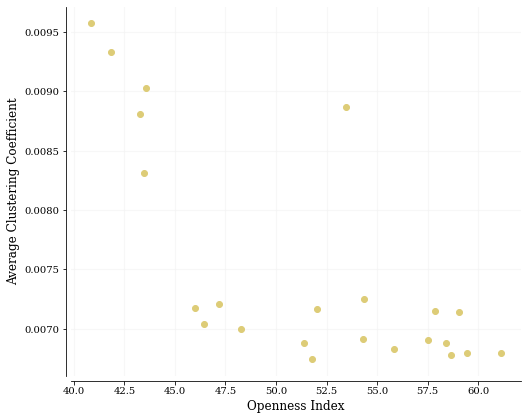

In [95]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.scatter(sumdf['OPIX'], sumdf['Average Clustering Coefficient'], label='Clustering Coefficient', color=cmap(2))

ax.set_xlabel('Openness Index')
ax.set_ylabel('Average Clustering Coefficient')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=-0.11, ymax=-0.06)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

plt.draw()

## save figure to file
fig.savefig('../../figures/'+'clustering_2'+'.png', dpi=300)

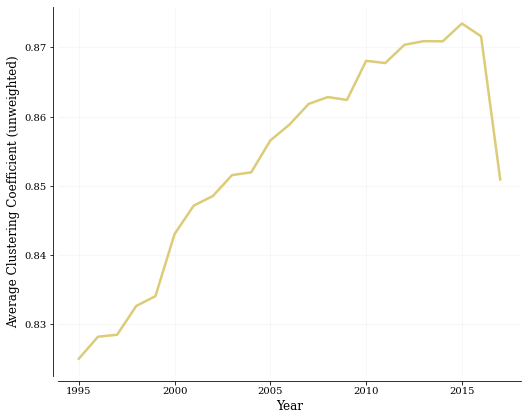

In [23]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.plot(sumdf['Year'], sumdf['Average Clustering Coefficient unweighted'], label='Clustering Coefficient', color=cmap(2), lw=2.5)

ax.set_xlabel('Year')
ax.set_ylabel('Average Clustering Coefficient (unweighted)')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=-0.11, ymax=-0.06)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

plt.draw()

## save figure to file
fig.savefig('../../figures/'+'clustering_3'+'.png', dpi=300)

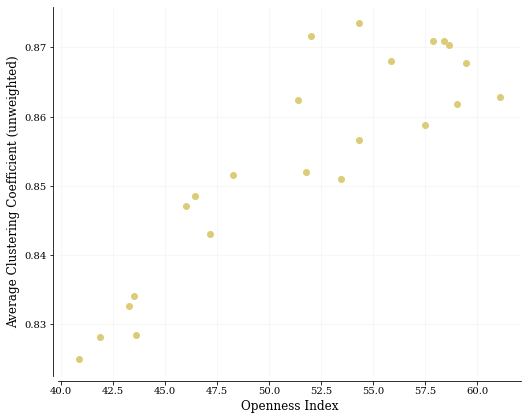

In [22]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.scatter(sumdf['OPIX'], sumdf['Average Clustering Coefficient unweighted'], label='Clustering Coefficient', color=cmap(2))

ax.set_xlabel('Openness Index')
ax.set_ylabel('Average Clustering Coefficient (unweighted)')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=-0.11, ymax=-0.06)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

plt.draw()

## save figure to file
fig.savefig('../../figures/'+'clustering_4'+'.png', dpi=300)

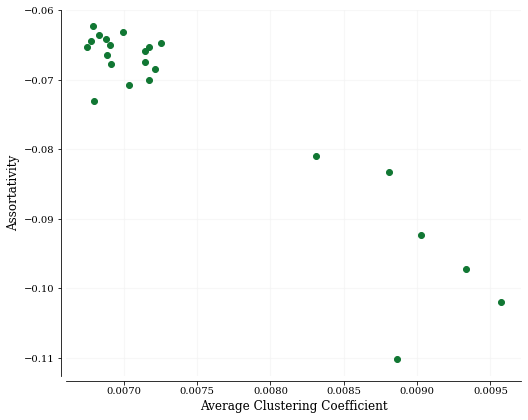

In [98]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.scatter(sumdf['Average Clustering Coefficient'], sumdf['Assortativity'], color=cmap(3))

ax.set_ylabel('Assortativity')
ax.set_xlabel('Average Clustering Coefficient')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=-0.11, ymax=-0.06)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

plt.draw()

## save figure to file
fig.savefig('../../figures/'+'assclust'+'.png', dpi=300)

## Plotting

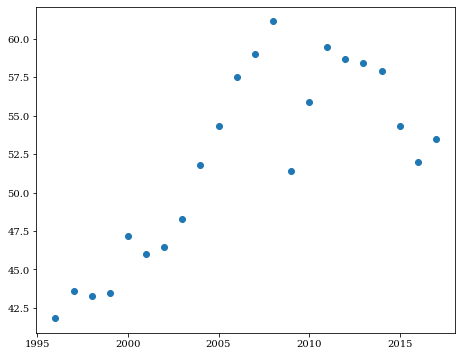

In [87]:
plt.scatter(sumdf['Year'],sumdf['OPIX'])

In [77]:
### Openness Index

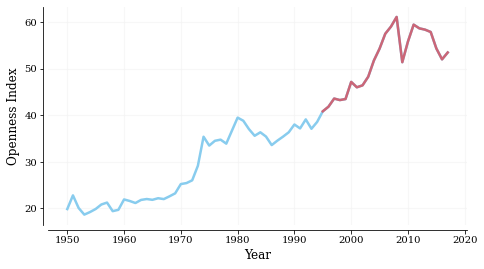

In [73]:
fig = plt.figure(figsize=(7.5,4))
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.plot(OPIX2['Year'], OPIX2['OPIX'], label='Openness Index', color=cmap(0), lw=2.5)
ax.plot(sumdf['Year'], sumdf['OPIX'], label='Openness Index', color=cmap(1), lw=2.5)


ax.set_xlabel('Year')
ax.set_ylabel('Openness Index')


#ax.set_xlim(xmin=1995, xmax=2017)
#ax.set_ylim(ymin=0.0, ymax=0.3)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
#fig.tight_layout()

#handles, labels = ax.get_legend_handles_labels()
#legend = fig.legend(handles, labels,
#            loc = 1, fancybox=True, shadow=False, scatterpoints=1, markerscale=15,
#            ncol=1, labelspacing=1.2, handlelength=1.2)
#legend.get_frame().set_facecolor('1.0')
#legend.get_frame().set_edgecolor('1.0')


plt.draw()
## show figure
# plt.show()

## save figure to file
fig.savefig('../../figures/'+'opix'+'.png', dpi=300)

### Centrality

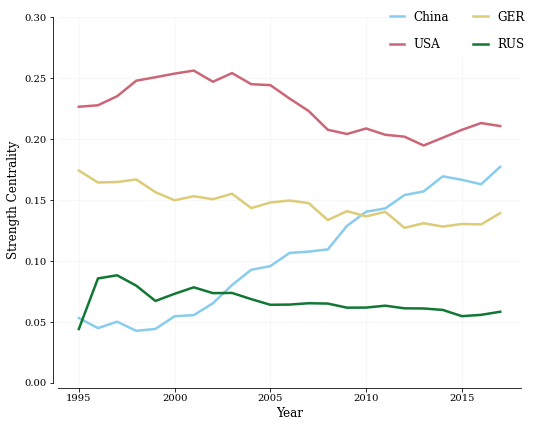

In [75]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.plot(sumdf['Year'], sumdf['Strength Centrality China'], label='China', color=cmap(0), lw=2.5)
ax.plot(sumdf['Year'], sumdf['Strength Centrality USA'], label='USA', color=cmap(1), lw=2.5)
ax.plot(sumdf['Year'], sumdf['Strength Centrality GER'], label='GER', color=cmap(2), lw=2.5)
ax.plot(sumdf['Year'], sumdf['Strength Centrality RUS'], label='RUS', color=cmap(3), lw=2.5)


ax.set_xlabel('Year')
ax.set_ylabel('Strength Centrality')


#ax.set_xlim(xmin=1995, xmax=2017)
ax.set_ylim(ymin=0.0, ymax=0.3)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(handles, labels,
            loc = 1, fancybox=True, shadow=False, scatterpoints=1, markerscale=15,
            ncol=2, labelspacing=1.2, handlelength=1.2)
legend.get_frame().set_facecolor('1.0')
legend.get_frame().set_edgecolor('1.0')


plt.draw()
## show figure
# plt.show()

## save figure to file
fig.savefig('../../figures/'+'strength_centrality'+'.png', dpi=300)

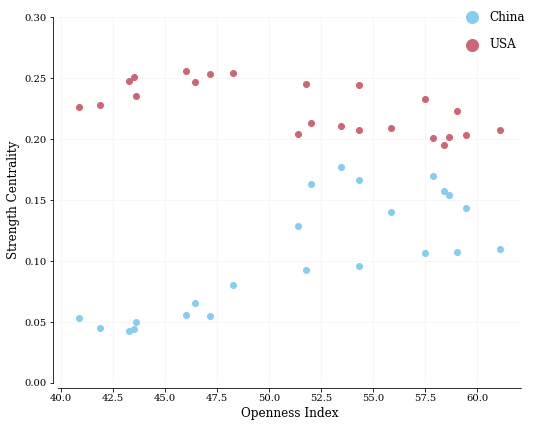

In [71]:
fig = plt.figure()
ax = plt.axes()

ax.grid(color="0.95", linestyle='-', linewidth=1.2, alpha=0.6)

ax.scatter(sumdf['OPIX'], sumdf['Strength Centrality China'], label='China', color=cmap(0))
ax.scatter(sumdf['OPIX'], sumdf['Strength Centrality USA'], label='USA', color=cmap(1))
#ax.scatter(sumdf['OPIX'], sumdf['Strength Centrality GER'], label='GER', color=colors[1], lw=1.4)
#ax.scatter(sumdf['OPIX'], sumdf['Strength Centrality RUS'], label='RUS', color=colors[0], lw=1.4)


ax.set_xlabel('Openness Index')
ax.set_ylabel('Strength Centrality')


#ax.set_xlim(xmin=1995, xmax=2017)
ax.set_ylim(ymin=0.0, ymax=0.3)
ax.tick_params(pad=2.8, labelbottom=False, labeltop=True, labelleft=True, labelright=False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x', direction='out')
ax.tick_params(axis='y', direction='out')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for spine in ax.spines.values():
    spine.set_position(('outward', 5))
    
ax.set_axisbelow(True)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(handles, labels,
            loc = 1, fancybox=True, shadow=False, scatterpoints=1, markerscale=2,
            ncol=1, labelspacing=1.2, handlelength=1.2)
legend.get_frame().set_facecolor('1.0')
legend.get_frame().set_edgecolor('1.0')


plt.draw()
## show figure
# plt.show()

## save figure to file
fig.savefig('../../figures/'+'strength_centrality_2'+'.png', dpi=300)

# Null Model

In [108]:
## read in weighted average, undirected trade data
data_avg = pd.read_pickle('../../data/baci_weighted_average_null.pkl')

# Minimal Spanning Trees

In [29]:
T = nx.minimum_spanning_tree(G07.to_undirected(), weight='v_minmax_scale', algorithm='kruskal', ignore_nan=True)

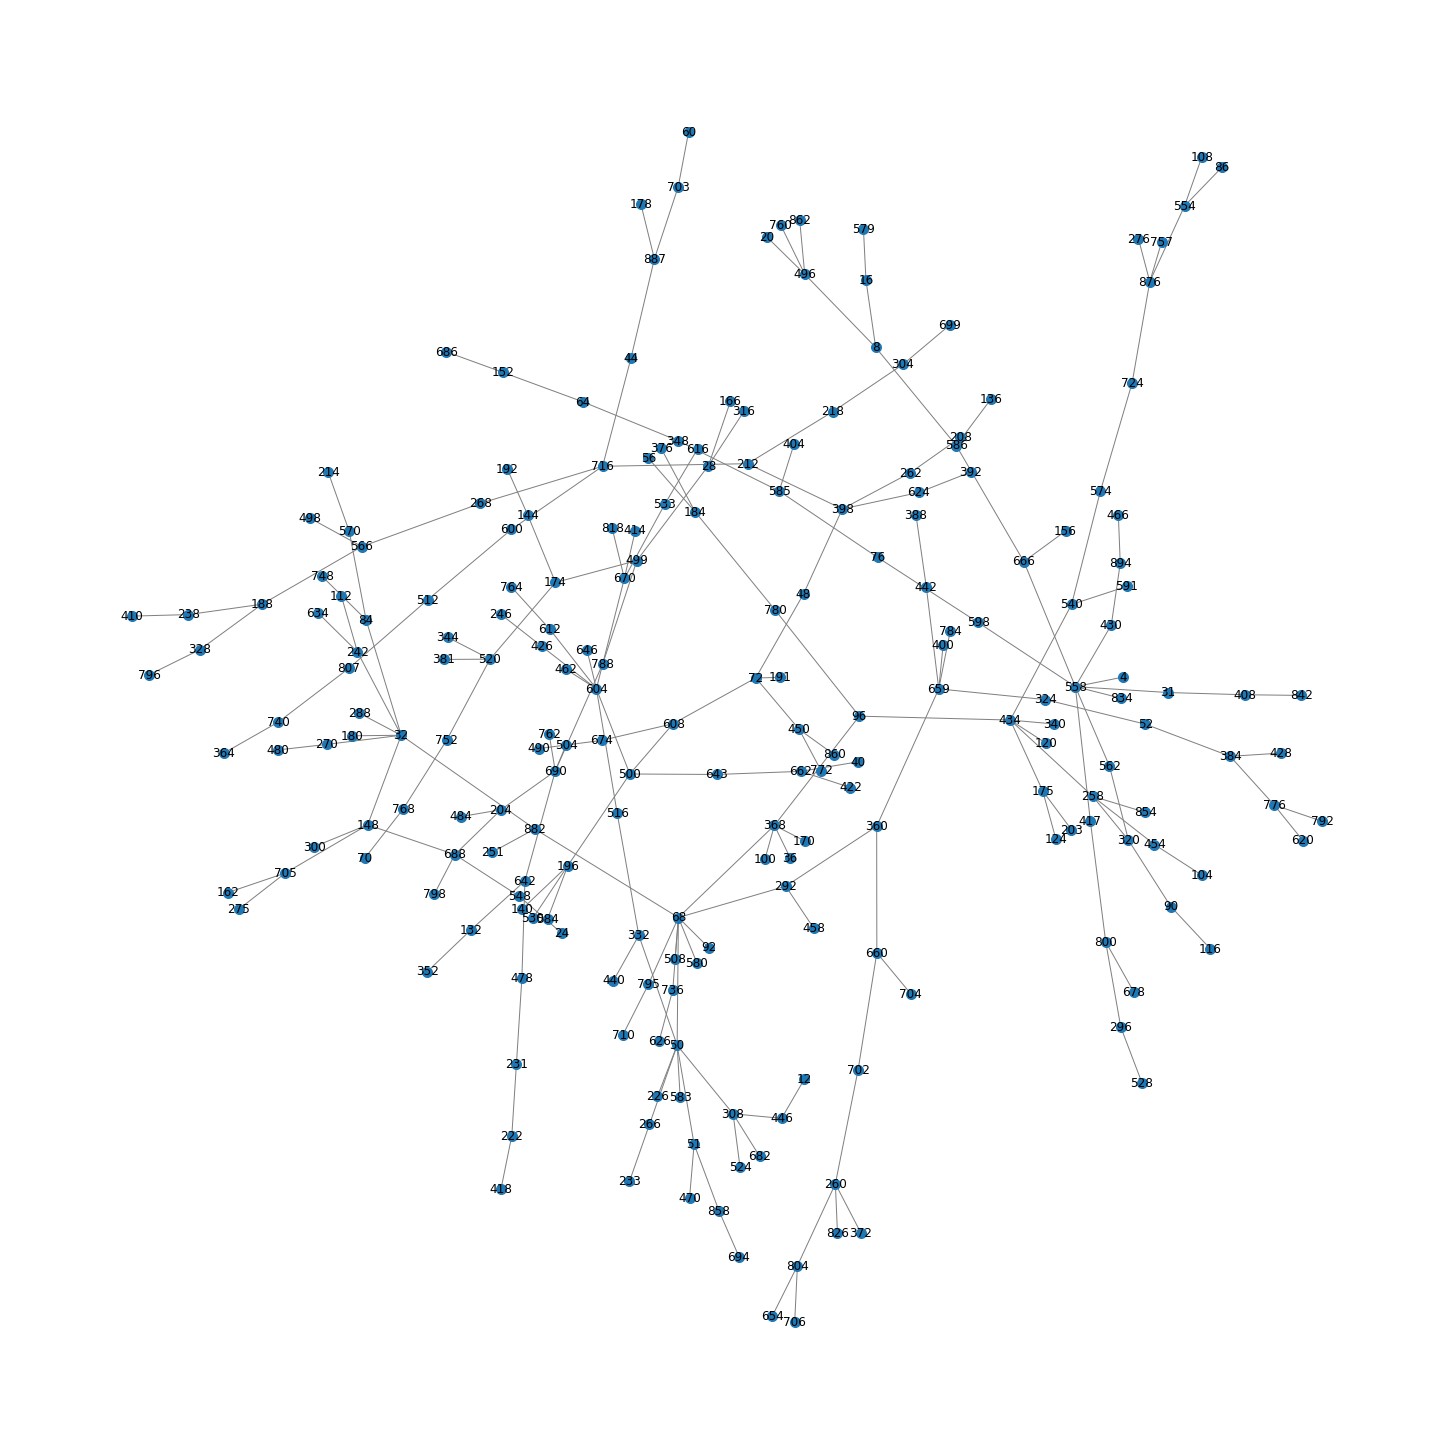

In [30]:
plt.figure(1,figsize=(20,20)) 
nx.draw(T, with_labels=True, node_size=100, edge_color='grey')



## Multipolarity

In [33]:
nx.resistance_distance(G96, 156, 842, weight='v_normalised')

5.482471573333552e-05

In [34]:
nx.resistance_distance(G18, 156, 842, weight='v_normalised')

3.358685606023053e-05

In [11]:
nx.barycenter(G17, weight='v_normalised')

[724]

# Community Detection

In [6]:
country_codes = pd.read_csv('../../data/raw/country_codes_V202102.csv', sep=',', quotechar='"', encoding='cp1252')

In [7]:
country_codes

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND
...,...,...,...,...,...
233,876,Wallis and Futuna Isds,Wallis and Futuna Islands,WF,WLF
234,882,Samoa,Samoa,WS,WSM
235,887,Yemen,Yemen,YE,YEM
236,891,Serbia and Montenegro,Serbia and Montenegro,CS,SCG


In [13]:
orders = nx.algorithms.community.kernighan_lin_bisection(N16, partition=None, max_iter=10, weight='weight', seed=None)

In [14]:
country_labels = dict(zip(country_codes.country_code, country_codes.iso_3digit_alpha))
#country_labels[16]

order_0 = []
for i in list(orders[0]):
    order_0.append(country_labels[i])
    
order_0 = pd.DataFrame(order_0, columns=['iso3_import'])

order_0['value'] = 1
#order_0

In [15]:
import folium
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
plotdf = world.merge(order_0, how="left", left_on=['iso_a3'], right_on=['iso3_import'])
plotdf.dropna(inplace=True)

display(plotdf)

# Create a map
my_map = folium.Map()

# Add the data
folium.Choropleth(
    geo_data=plotdf,
    name='bounded orders',
    data=plotdf,
    columns=['iso3_import', 'value'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='test'
).add_to(my_map)
my_map.save('2orders.html')

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,iso3_import,value
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,1.0
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,1.0
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,1.0
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819 41.30864, 55.92892 44.99586...",UZB,1.0
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ...",PNG,1.0
...,...,...,...,...,...,...,...,...
152,5445829,Europe,Slovakia,SVK,168800.0,"POLYGON ((22.55814 49.08574, 22.28084 48.82539...",SVK,1.0
153,10674723,Europe,Czechia,CZE,350900.0,"POLYGON ((15.01700 51.10667, 15.49097 50.78473...",CZE,1.0
155,126451398,Asia,Japan,JPN,4932000.0,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",JPN,1.0
157,28036829,Asia,Yemen,YEM,73450.0,"POLYGON ((52.00001 19.00000, 52.78218 17.34974...",YEM,1.0


In [16]:
my_map

In [116]:

#import networkx as nx
#import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pathlib

import infomap

"""
Generate and draw a network with NetworkX, colored
according to the community structure found by Infomap.
"""


def find_communities(G):
    """
    Partition network with the Infomap algorithm.
    Annotates nodes with 'community' id.
    """

    im = infomap.Infomap("--two-level")

    print("Building Infomap network from a NetworkX graph...")

    im.add_networkx_graph(G)

    print("Find communities with Infomap...")
    im.run()

    print(f"Found {im.num_top_modules} modules with codelength: {im.codelength}")

    communities = im.get_modules()
    nx.set_node_attributes(G, communities, 'community')


def draw_network(G):
    # position map
    pos = nx.spring_layout(G)
    # community index
    communities = [c - 1 for c in nx.get_node_attributes(G, 'community').values()]
    num_communities = max(communities) + 1

    # color map from http://colorbrewer2.org/
    cmap_light = colors.ListedColormap(
        ['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', num_communities)
    cmap_dark = colors.ListedColormap(
        ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', num_communities)

    # edges
    nx.draw_networkx_edges(G, pos)

    # nodes
    node_collection = nx.draw_networkx_nodes(
        G, pos=pos, node_color=communities, cmap=cmap_light)

    # set node border color to the darker shade
    dark_colors = [cmap_dark(v) for v in communities]
    node_collection.set_edgecolor(dark_colors)

    # Print node labels separately instead
    for n in G.nodes:
        plt.annotate(n,
                     xy=pos[n],
                     textcoords='offset points',
                     horizontalalignment='center',
                     verticalalignment='center',
                     xytext=[0, 2],
                     color=cmap_dark(communities[n]))

    plt.axis('off')
    pathlib.Path("output").mkdir(exist_ok=True)
    print("Writing network figure to output/karate.png")
    plt.savefig("output/karate.png")
    # plt.show()


G = nx.karate_club_graph()

find_communities(G)
draw_network(G)

ImportError: dlopen(/opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so, 0x0002): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /opt/homebrew/anaconda3/envs/gp_lio_network/lib/python3.7/site-packages/_infomap.cpython-37m-darwin.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

# Graph Tool Analysis

In [ ]:
## prepare data

In [91]:
# import 
country_codes = pd.read_csv('../../data/raw/country_codes_V202102.csv', sep=',', quotechar='"', encoding='cp1252')

country_codes

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND
...,...,...,...,...,...
233,876,Wallis and Futuna Isds,Wallis and Futuna Islands,WF,WLF
234,882,Samoa,Samoa,WS,WSM
235,887,Yemen,Yemen,YE,YEM
236,891,Serbia and Montenegro,Serbia and Montenegro,CS,SCG


In [93]:
labels = dict(zip(country_codes.country_code, country_codes.iso_3digit_alpha))
#labels

In [94]:
nx.set_node_attributes(N96, labels, name='names')
nx.set_node_attributes(N16, labels, name='names')

In [95]:
N96gt = nx2gt(N96)
N96gt.list_properties()

names            (vertex)  (type: string)
nodeid           (vertex)  (type: string)
v_minmax_avg     (edge)    (type: double)


In [105]:
N16gt = nx2gt(N16)
N16gt.list_properties()

names            (vertex)  (type: string)
nodeid           (vertex)  (type: string)
v_minmax_avg     (edge)    (type: double)


In [97]:
## Calculate States

In [108]:
state96 = minimize_nested_blockmodel_dl(N96gt)
state16 = minimize_nested_blockmodel_dl(N16gt)

In [109]:
## draw

In [115]:
state96.draw(vertex_text=N96gt.vertex_properties['names'], vertex_font_size=12, vertex_text_position='centered',output="../../figures/96_communities.png")

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x170369370, at 0x18b029400>,
 <Graph object, directed, with 217 vertices and 216 edges, at 0x152804b50>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x152804b50, at 0x18b024e50>)

In [116]:
state16.draw(vertex_text=N16gt.vertex_properties['names'], vertex_font_size=12, vertex_text_position='centered',output="../../figures/16_communities.png")

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x152820a60, at 0x18b029e20>,
 <Graph object, directed, with 217 vertices and 216 edges, at 0x18b01c880>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x18b01c880, at 0x18b024310>)

In [41]:
# Now we run 1,000 sweeps of the MCMC. Note that the number of groups
# is allowed to change, so it will eventually move from the initial
# value of B=1 to whatever is most appropriate for the data.

dS, nattempts, nmoves = state.multiflip_mcmc_sweep(niter=1000)

print("Change in description length:", dS)
print("Number of accepted vertex moves:", nmoves)

Change in description length: 20.20300090979713
Number of accepted vertex moves: 141305


In [43]:
# We will accept equilibration if 10 sweeps are completed without a
# record breaking event, 2 consecutive times.

mcmc_equilibrate(state, wait=10, nbreaks=2, mcmc_args=dict(niter=10))

(14875.225669358882, 318396, 61984)

In [55]:
h = np.zeros(N96gt.num_vertices() + 1)

def collect_num_groups(s):
    B = s.get_nonempty_B()
    h[B] += 1

# Now we collect partitions for exactly 100,000 sweeps, at intervals
# of 10 sweeps:
mcmc_equilibrate(state, force_niter=10000, mcmc_args=dict(niter=10),
                    callback=collect_num_groups)

(14914.828587666743, 1194163, 410728)

In [61]:
h

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

(array([206.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <BarContainer object of 10 artists>)

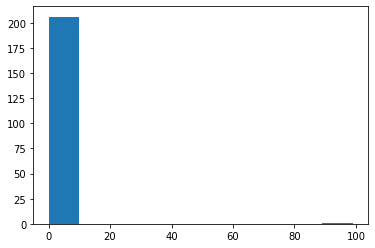

In [60]:
plt.hist(h)

In [45]:
# We will first equilibrate the Markov chain
mcmc_equilibrate(state, wait=1000, mcmc_args=dict(niter=10))

bs = [] # collect some partitions

def collect_partitions(s):
   global bs
   bs.append(s.b.a.copy())

# Now we collect partitions for exactly 100,000 sweeps, at intervals
# of 10 sweeps:
mcmc_equilibrate(state, force_niter=1000, mcmc_args=dict(niter=10),
                    callback=collect_partitions)

# Disambiguate partitions and obtain marginals
pmode = PartitionModeState(bs, converge=True)
pv = pmode.get_marginal(N96gt)

# Now the node marginals are stored in property map pv. We can
# visualize them as pie charts on the nodes:
state.draw(vertex_shape="pie", vertex_pie_fractions=pv)

KeyboardInterrupt: 